In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

In [2]:
# Step 1: Define problem parameters
L = 50  # Length of domain in x and y directions
T0 = 100
Nx, Ny = 50, 50  # Number of grid points in x and y
alpha = 6  # Thermal diffusivity
dt = 0.0125  # Time step size
nt = 500  # Number of time steps

device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
dtype = torch.float64
print(device)

cuda


In [3]:
def apply_boundary_condition(A, b):
    pass

In [4]:
def apply_preconditioner(PC, r, tol=1e-6, max_iter=10):
    # z = torch.zeros_like(r, device=device, dtype=dtype)  # Initial guess for z
    # for _ in range(max_iter):
    #     # Jacobi preconditioner: Solve Mz = r approximately
    #     z_new = r / torch.diag(M)  # Jacobi step
    #     if torch.norm(z_new - z) < tol:
    #         break
    #     z = z_new
    
    # z = torch.linalg.solve(PC, r)

    z = (1 / PC) * r
    return z

def conjugate_gradient(A, b, M, a_tol=1e-6, r_tol=1e-6, max_iter=100):
    
    x = torch.zeros_like(b, device=device, dtype=dtype)  # Initial guess (zero vector)
    r = b - A @ x            # Initial residual
    z = apply_preconditioner(M, r)  # Preconditioned residual
    p = z                    # Initial search direction

    r_norm = torch.linalg.vector_norm(r)
    
    for i in range(max_iter):
        Ap = A @ p           # Matrix-vector product A*p
        rz_scala = torch.dot(r, z)
        alpha =  rz_scala / torch.dot(p, Ap)  # Step size
        
        # Update the solution
        x = x + alpha * p
        
        # Update residual
        r_new = r - alpha * Ap
        # print("alpha", alpha)
        # print("Ap", torch.norm(Ap))
        # Check for convergence
        
        r_new_norm = torch.linalg.vector_norm(r_new)
        # print(r_new_norm / r_norm)

        # Check if the residual norm is increasing, implying divergence
        # if r_new_norm > r_norm:
        #     print(f"Residual norm increased at iteration {i}, stopping early.")
        #     break
        
        if r_new_norm < a_tol or (r_new_norm / r_norm) < r_tol:
            print(f"Converged in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
            break
        
        # Apply the preconditioner iteratively
        z_new = apply_preconditioner(M, r_new)
        
        # Compute beta for the next search direction
        beta = torch.dot(r_new, z_new) / rz_scala
        
        # Update the search direction
        p = z_new + beta * p
        
        # Update residuals and preconditioned residuals for next iteration
        r = r_new
        z = z_new

    # exception
    # else:
    #     raise Exception("did not converge")
    
    return x

In [5]:
# Step 2: Generate grid (structured triangular mesh)
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)
triangulation = tri.Triangulation(X.flatten(), Y.flatten())

In [6]:
# Step 3: Initial condition
u0 = torch.zeros((L * L)).to(device=device, dtype=dtype)
u0[: L] = T0

In [7]:
def assemble_matrices(triangulation, alpha):
    npoints = len(triangulation.x)  # Total number of points in the mesh
    K = torch.zeros((npoints, npoints))  # Global stiffness matrix
    M = torch.zeros((npoints, npoints)) # Global mass matrix
    
    for element in triangulation.triangles:
        # Get the coordinates of the three vertices of the triangle
        vertices = element[:]
        x_coords = triangulation.x[vertices]
        
        y_coords = triangulation.y[vertices]
        # Compute area of the triangle (used in both stiffness and mass matrices)
        area = 0.5 * abs(
            x_coords[0] * (y_coords[1] - y_coords[2]) +
            x_coords[1] * (y_coords[2] - y_coords[0]) +
            x_coords[2] * (y_coords[0] - y_coords[1])
        )
        # Local stiffness matrix (based on gradients of linear basis functions)
        Ke = (alpha / (4 * area)) * torch.tensor([[2, -1, -1],
                                                 [-1, 2, -1],
                                                 [-1, -1, 2]])
        
        # Local mass matrix (based on linear basis functions)
        Me = (area / 12) * torch.tensor([[2, 1, 1],
                                        [1, 2, 1],
                                        [1, 1, 2]])
        
        # Add local contributions to the global matrices
        for i in range(3):
            for j in range(3):
                K[vertices[i], vertices[j]] += Ke[i, j]
                M[vertices[i], vertices[j]] += Me[i, j]
    
    return K, M

K, M = assemble_matrices(triangulation, alpha)
K = K.to(device=device, dtype=dtype)
M = M.to(device=device, dtype=dtype)

In [8]:
# Step 5: Time-stepping loop (Forward Euler)
U = torch.zeros((nt, L, L)).to(device=device, dtype=dtype)
U[0,:,:] = u0.reshape((L, L))

u = u0
M_dt = M * (1 / dt)
A = M_dt + K

dirichlet_boundary_nodes = torch.arange(L, device=device)
boundary_values = torch.ones_like(dirichlet_boundary_nodes, dtype=dtype, device=device) * T0

A[dirichlet_boundary_nodes, :] = 0.0 # apply boundary condition
A[dirichlet_boundary_nodes, dirichlet_boundary_nodes] = 1.0

PC = torch.diag(A)

# PC = A.clone()
PC = PC.to(device=device, dtype=dtype)
for n in range(1, nt):
    print(f"{n}", end=" ")
    b = M_dt @ u
    
    b[dirichlet_boundary_nodes] = boundary_values # apply boundary condition
    u = conjugate_gradient(A, b, PC, a_tol=1e-5, r_tol=1e-5, max_iter=100)
    
    U[n, :, :] = u.reshape((L, L))

1 2 3 Converged in 25 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
4 Converged in 18 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
5 Converged in 17 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
6 Converged in 17 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
7 Converged in 17 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
8 Converged in 13 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
9 Converged in 13 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
10 Converged in 13 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
11 Converged in 13 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
12 Converged in 13 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
13 Converged in 13 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
14

In [9]:
def plotheatmap(tr, u_k , k):
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.tripcolor(tr, u_k.flatten(), cmap=plt.cm.jet, vmin=0, vmax=100, shading='gouraud')
    plt.colorbar()

In [10]:
U = U.cpu()

In [11]:
def animate(k):
    plotheatmap(triangulation, U[k], k)

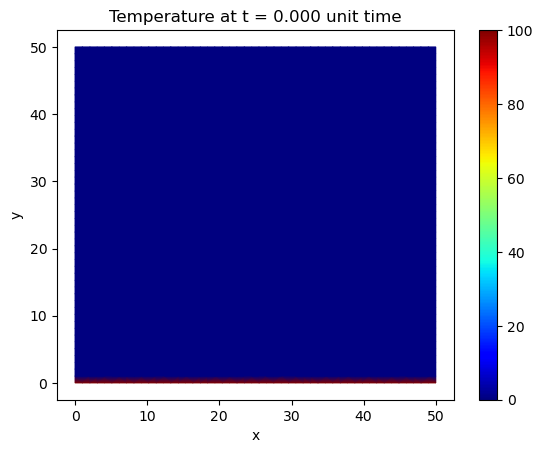

In [12]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=nt, repeat=False)
anim.save("FEM - 2D Heat Equation - PCG - Dense.gif")